In [48]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy.signal import welch, firwin, filtfilt, hilbert
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import normalize 
from time import gmtime
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.cluster import KMeans
from scipy.stats import wilcoxon

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [66]:
pylab.rcParams['figure.figsize'] = (14, 10)

In [6]:
path = "/Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/"
files = [
    "2017/25-12-2017_17-24.bdf",
    "2017/29-12-2017_16-18.bdf",
    "2018/02-01-2018_19-06.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/10-01-2018_15-09.bdf",
    "2018/13-01-2018_19-37.bdf",
    "2018/15-01-2018_18-07.bdf",
]

In [7]:
def skip_damaged_epoch(start_time):
    """
    """
    
    n_skip = 0
    
    # skip seconds
    
    if start_time[5] > 0:
        n_skip += (60-start_time[5])*fs
        
        start_time[5] = 0
        start_time[4] += 1
        
    # skip minutes
    
    dummy = str(start_time[4])
    
    if len(dummy) == 2:
        ones = int(dummy[1])
        tens = int(dummy[0])
    else:
        ones = int(dummy[0])
        tens = 0
    
    if ones > 0:
        n_skip += (10-ones)*fs*60
        
        if tens == 5:
            start_time[4] = 0
            start_time[3] += 1
        else:
            start_time[4] += (10-ones) #TODO 
    
    return n_skip

In [13]:
temp = pd.read_csv("/Users/wassilyminkow/Data/Rat_Data/RatTemperature.csv", sep=",")
temp["Power"] = np.nan 
temp["Acceleration"] = np.nan 
    
path = "/Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/"
files = [
    "2017/25-12-2017_17-24.bdf",
    "2017/29-12-2017_16-18.bdf",
    "2018/02-01-2018_19-06.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/06-01-2018_18-33.bdf",
    "2018/10-01-2018_15-09.bdf",
    "2018/13-01-2018_19-37.bdf",
]
    
fs = 250
    
for file in files:
    
    # read EEG and acceleration data
    raw_data = mne.io.read_raw_edf(path+file)
    df = pd.DataFrame(raw_data.get_data([0, 2]), index=[raw_data.ch_names[0], raw_data.ch_names[2]]).T
    
    # 
    start = list(gmtime(raw_data.info['meas_date'][0]))
    
    n_skip = skip_damaged_epoch(start)
    
    df_new = df.iloc[n_skip:, ]
    
    n_epocs = int(np.floor(df_new.shape[0]/fs/60/10))
    n_samples = int(n_epocs*10*60*fs)
    
    df_epocs = df_new.iloc[:n_samples, :]
    
    start_epoc = temp[(temp['Year']==start[0])&(temp['Month']==start[1])&(temp['Day']==start[2])&(temp['Hour']==start[3])&(temp['Minute']==start[4])].index[0]
    
    temp_epocs = temp.iloc[start_epoc:start_epoc+n_epocs, -1]
    
    n_slises = 20
    step = fs*60*10
    
    sum_power = np.array(list(map(lambda i: (df_epocs.iloc[i*step:(i+1)*step, 0]**2).mean(), np.arange(n_epocs))))
    sum_a = np.array(list(map(lambda i: (np.abs(df_epocs.iloc[i*step:(i+1)*step, 1]-df_epocs.iloc[i*step:(i+1)*step, 1].mean())).mean(), np.arange(n_epocs))))
    
    temp.iloc[start_epoc:start_epoc+n_epocs,-2] = sum_power*1e3
    temp.iloc[start_epoc:start_epoc+n_epocs,-1] = sum_a*1e-1

Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2017/25-12-2017_17-24.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2017/29-12-2017_16-18.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/02-01-2018_19-06.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/06-01-2018_18-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/06-01-2018_18-33.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/10-01-2018_15-09.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


Extracting EDF parameters from /Users/wassilyminkow/Data/Rat_Data/25-12-2017_17-24_torpor_starts/2018/13-01-2018_19-37.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-13-af79e2886eb5>:22: DeprecationWarning: stim_channel will default to "auto" in 0.17 but change to False in 0.18, and will be removed in 0.19
  raw_data = mne.io.read_raw_edf(path+file)
<ipython-input-13-af79e2886eb5>:22: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_data = mne.io.read_raw_edf(path+file)


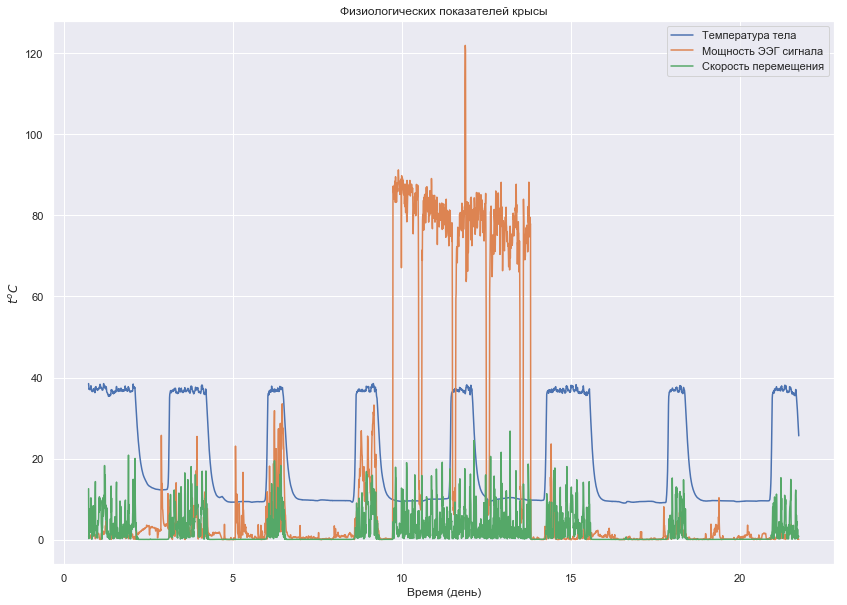

In [22]:
time_array = temp.dropna().index/6/24

plt.plot(time_array, temp.dropna().iloc[:, -3], label="Температура тела") 
plt.plot(time_array, temp.dropna().iloc[:, -2], label="Мощность ЭЭГ сигнала")
plt.plot(time_array, temp.dropna().iloc[:, -1], label="Скорость перемещения")

plt.title("Физиологические показатели крысы")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

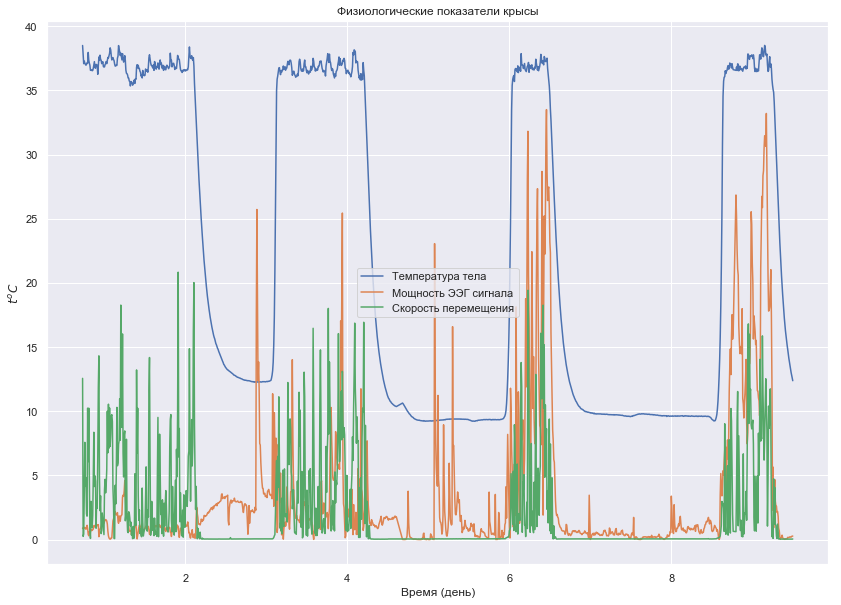

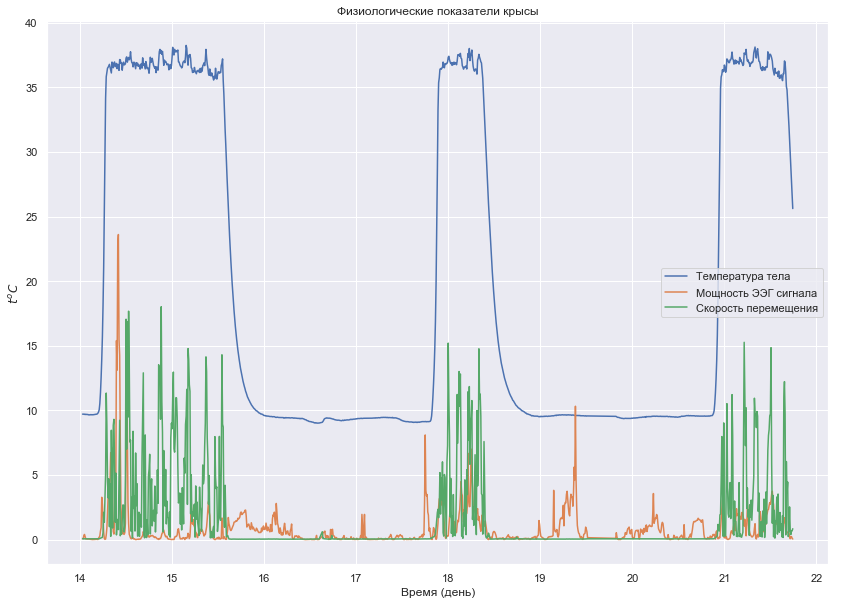

In [166]:
time_array = temp.dropna().index/6/24

skip_start = 1250
skip_end = 1900

plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -3], label="Температура тела") 
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -2], label="Мощность ЭЭГ сигнала")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -1], label="Скорость перемещения")

plt.title("Физиологические показатели крысы")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -3], label="Температура тела") 
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -2], label="Мощность ЭЭГ сигнала")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -1], label="Скорость перемещения")

plt.title("Физиологические показатели крысы")
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

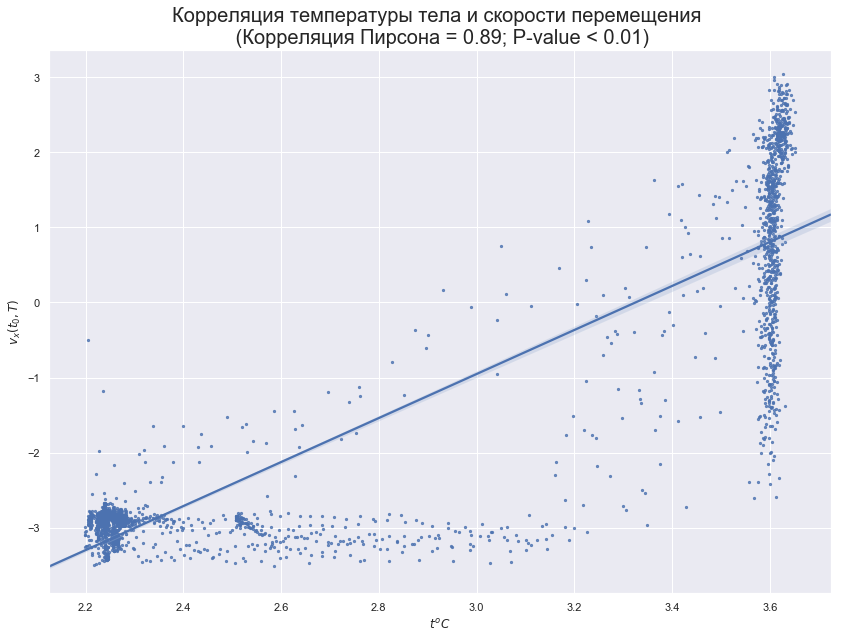

In [238]:
x = np.log(pd.concat([temp.dropna().iloc[:skip_start, -3], temp.dropna().iloc[skip_end:, -3]], axis=0))
y = np.log(pd.concat([temp.dropna().iloc[:skip_start, -1], temp.dropna().iloc[skip_end:, -1]], axis=0))

ans = pearsonr(x, y)

dummy = round(ans[0], 2)
if ans[1] < 0.01: 
    ans = [dummy, "< 0.01"]
else:
    ans = [dummy, "= {}".format(round(ans[1], 2))]

sns.regplot(x=x, y=y, marker=".", scatter_kws={"s": 20})
plt.title("Корреляция температуры тела и скорости перемещения \n (Корреляция Пирсона = {}; P-value {})".format(ans[0], ans[1]), fontsize=20)
plt.ylabel(r"$v_{x}(t_0, T)$")
plt.xlabel(r"$t^o C$")
plt.show()

/Users/wassilyminkow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/wassilyminkow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


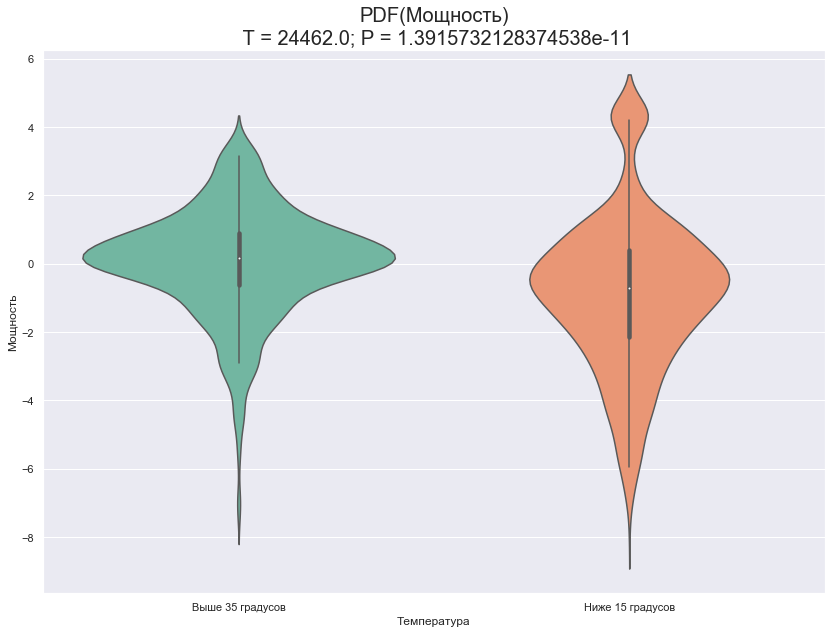

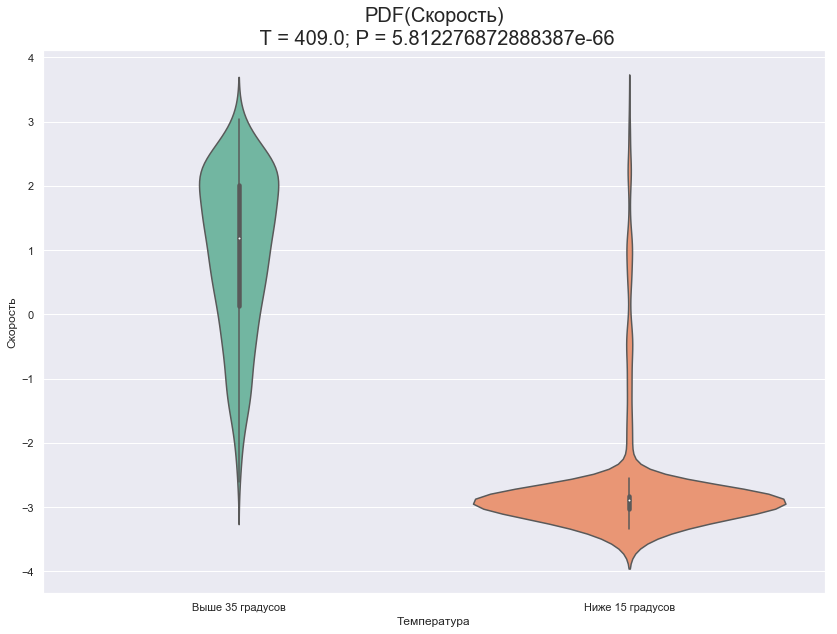

In [318]:
data = temp.copy()
data = pd.concat([data.iloc[:skip_start, :], data.iloc[skip_end:, :]], axis=0).dropna()

data["Температура"] = np.nan
data["Температура"][data["Temperature"] < 15] = "Ниже 15 градусов"
data["Температура"][data["Temperature"] > 35] = "Выше 35 градусов"

feature = ["Power", "Acceleration"]
rus_feature = ["Мощность", "Скорость"]

for i in range(2):
    data[feature[i]] = np.log(data[feature[i]])
    ans = wilcoxon(data[data["Температура"] == "Ниже 15 градусов"][feature[i]].sample(400), 
                   data[data["Температура"] == "Выше 35 градусов"][feature[i]].sample(400))
    sns.violinplot(x="Температура", y=feature[i], data=data, palette="Set2")
    plt.title("KDF({})\n T = {}; P = {}".format(rus_feature[i], ans[0], ans[1]), fontsize=20)
    plt.ylabel("{}".format(rus_feature[i]))
    plt.show()

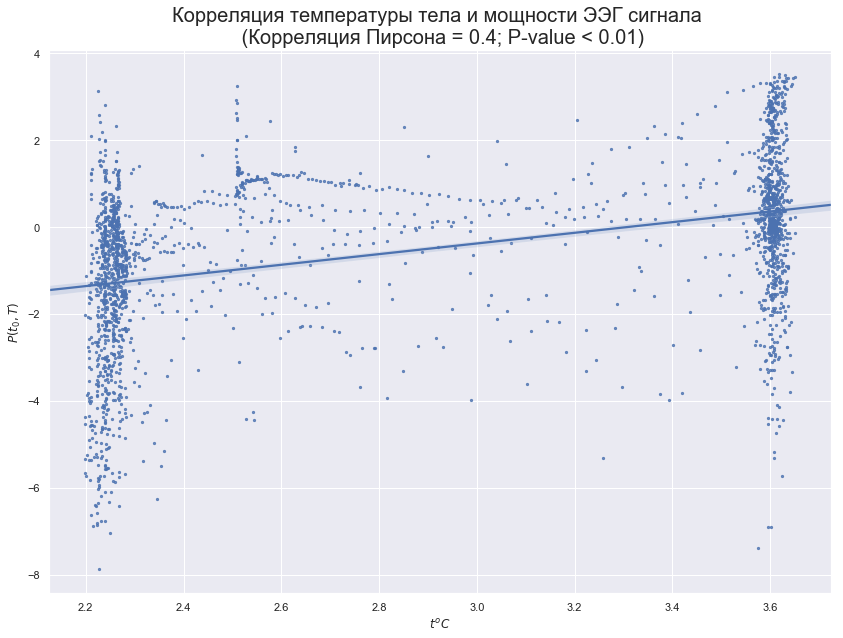

In [306]:
x = np.log(pd.concat([temp.dropna().iloc[:skip_start, -3], temp.dropna().iloc[skip_end:, -3]], axis=0))
y = np.log(pd.concat([temp.dropna().iloc[:skip_start, -2], temp.dropna().iloc[skip_end:, -2]], axis=0))

ans = pearsonr(x, y)

dummy = round(ans[0], 2)
if ans[1] < 0.01: 
    ans = [dummy, "< 0.01"]
else:
    ans = [dummy, "= {}".format(round(ans[1], 2))]

sns.regplot(x=x, y=y, marker=".", scatter_kws={"s": 20})
plt.title("Корреляция температуры тела и мощности ЭЭГ сигнала \n (Корреляция Пирсона = {}; P-value {})".format(ans[0], ans[1]), fontsize=20)
plt.ylabel(r"$P(t_0, T)$")
plt.xlabel(r"$t^o C$")
plt.show()

In [171]:
gap = 6*24  # set size of the rolling window 

x = np.log(temp.dropna().iloc[:, -3])  # temperature vector
y = np.log(temp.dropna().iloc[:, -2])  # power vector

p = np.zeros(x.shape[0]-gap) # p-value vector
c = np.zeros(x.shape[0]-gap) # statistic vector

# calculate the rolling corelation coefficient
for i in np.arange(x.shape[0]-gap):
    ans = pearsonr(x[i:i+gap], y[i:i+gap])
    c[i] = ans[0] 
    p[i] = ans[1]

# ajusting p-value with bonferroni method
p_adjusted = multipletests(p, method='bonferroni')

c1 = np.zeros(x.shape[0]-gap)
c2 = np.zeros(x.shape[0]-gap)
c3 = np.zeros(x.shape[0]-gap)

c_green = np.zeros(x.shape[0]-gap)
c_yellow = np.zeros(x.shape[0]-gap)
c_red = np.zeros(x.shape[0]-gap)

c1[(p < 0.05) & (np.abs(c) >= 0.9)] = 1
c2[(p < 0.05) & (np.abs(c) >= 0.7) & (np.abs(c) < 0.9)] = 1
c3[(p < 0.05) & (np.abs(c) >= 0.6) & (np.abs(c) < 0.7)] = 1
c1[c1 < 1] = 0
c2[c2 < 1] = 0
c3[c3 < 1] = 0

num = [c1, c2, c3]
col = [c_green, c_yellow, c_red]

z = list(zip(num, col))

counter = 0

for unit in z:
    for i in range(len(unit[0])):
        if unit[0][i] == 0:
            if counter == 0:
                unit[1][i] = NAN
            else:
                unit[1][i] = time_array[i]
                counter -= 1
        else:
            unit[1][i] = time_array[i]
            counter = gap

z[2][1][z[1][1] == 1] = nan
z[1][1][z[0][1] == 1] = nan
z[2][1][z[0][1] == 1] = nan

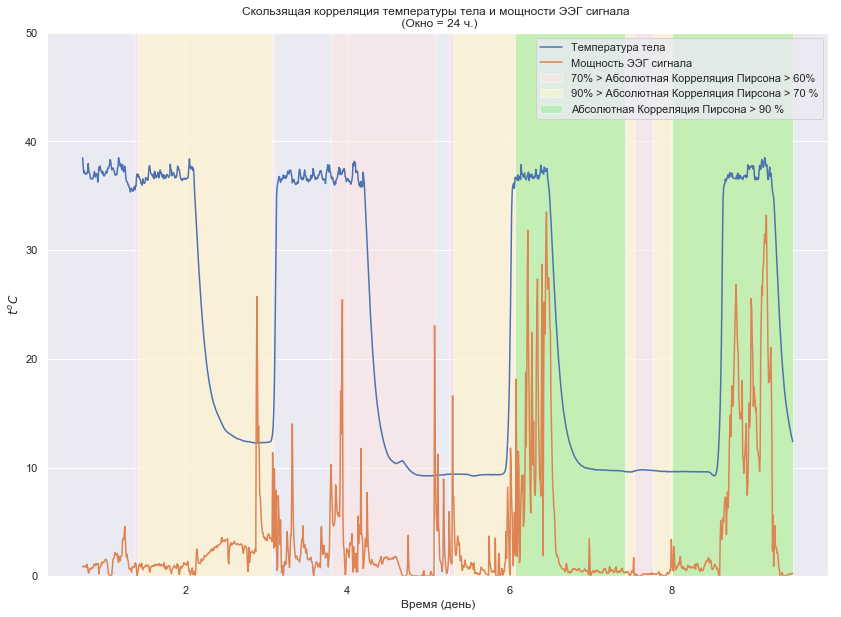

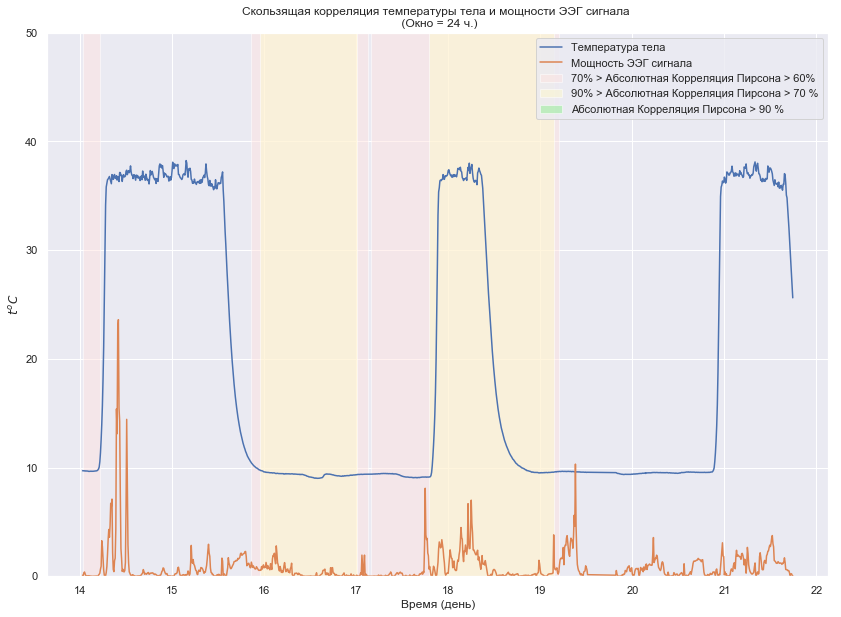

In [173]:
hight = 50

plt.title("Скользящая корреляция температуры тела и мощности ЭЭГ сигнала \n (Окно = 24 ч.)")
plt.fill_between(z[2][1][:skip_start], np.ones(z[0][1][:skip_start].shape[0])*hight, alpha=0.5, facecolor="mistyrose", label = "70% > Абсолютная Корреляция Пирсона > 60%")
plt.fill_between(z[1][1][:skip_start], np.ones(z[0][1][:skip_start].shape[0])*hight, alpha=0.5, facecolor="lemonchiffon", label = "90% > Абсолютная Корреляция Пирсона > 70 %")
plt.fill_between(z[0][1][:skip_start], np.ones(z[0][1][:skip_start].shape[0])*hight, alpha=0.5, facecolor="lightgreen", label = "Абсолютная Корреляция Пирсона > 90 %")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -3], label="Температура тела")
plt.plot(time_array[:skip_start], temp.dropna().iloc[:skip_start, -2], label="Мощность ЭЭГ сигнала")
plt.ylim([0,hight])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

plt.title("Скользящая корреляция температуры тела и мощности ЭЭГ сигнала \n (Окно = 24 ч.)")
plt.fill_between(z[2][1][skip_end:], np.ones(z[0][1][skip_end:].shape[0])*hight, alpha=0.5, facecolor="mistyrose", label = "70% > Абсолютная Корреляция Пирсона > 60%")
plt.fill_between(z[1][1][skip_end:], np.ones(z[0][1][skip_end:].shape[0])*hight, alpha=0.5, facecolor="lemonchiffon", label = "90% > Абсолютная Корреляция Пирсона > 70 %")
plt.fill_between(z[0][1][skip_end:], np.ones(z[0][1][skip_end:].shape[0])*hight, alpha=0.5, facecolor="lightgreen", label = "Абсолютная Корреляция Пирсона > 90 %")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -3], label="Температура тела")
plt.plot(time_array[skip_end:], temp.dropna().iloc[skip_end:, -2], label="Мощность ЭЭГ сигнала")
plt.ylim([0,hight])
plt.ylabel(r"$t^o C$")
plt.xlabel("Время (день)")
plt.legend()
plt.show()

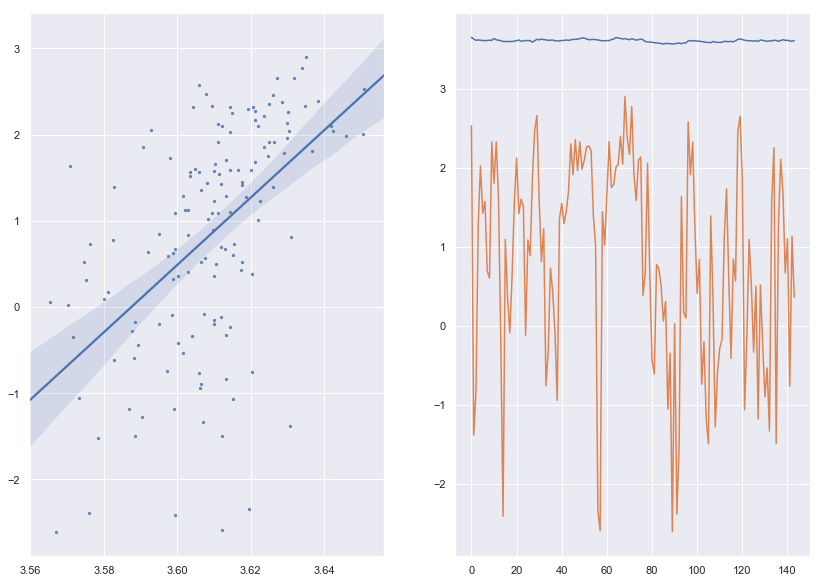

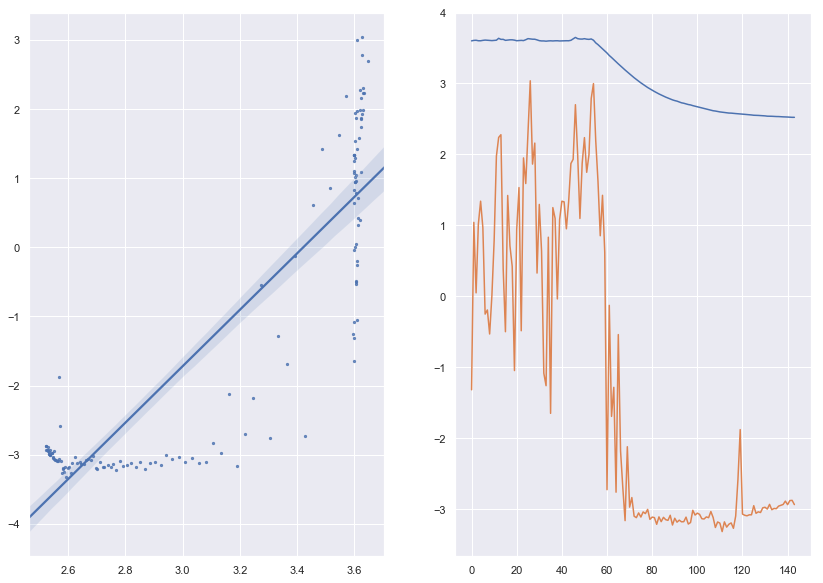

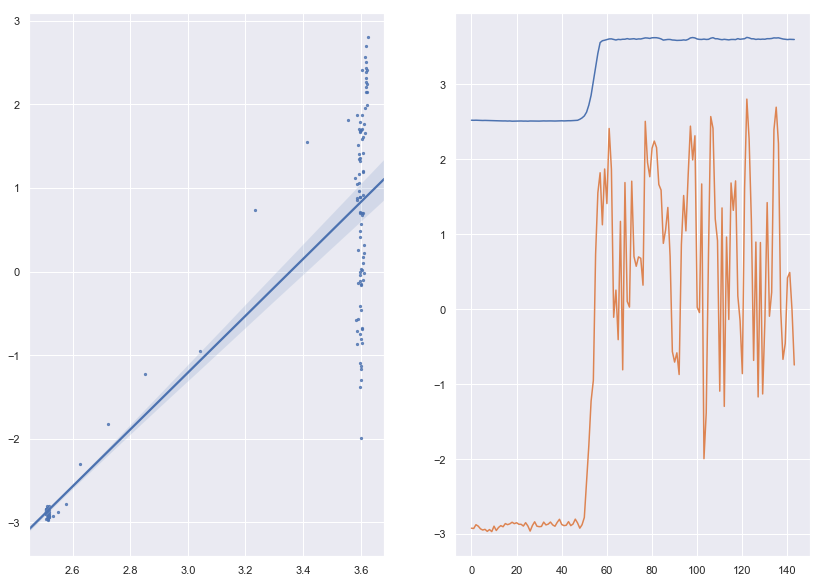

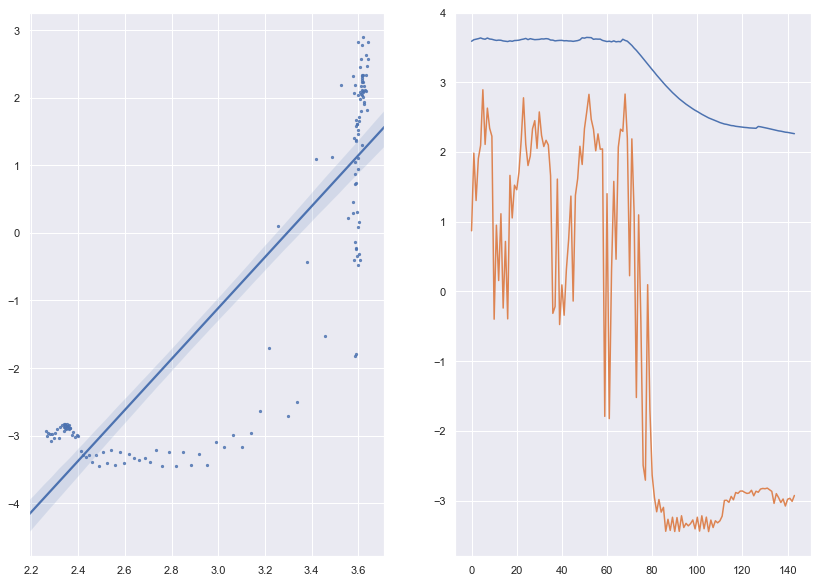

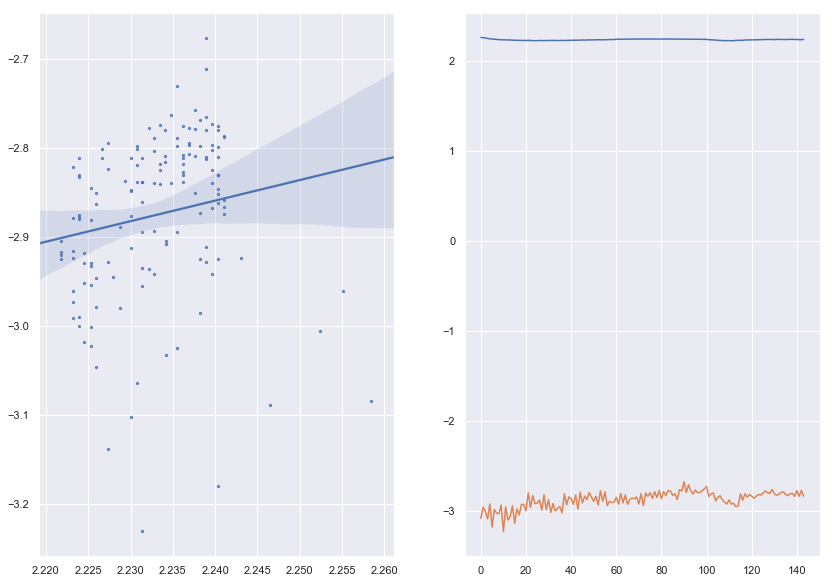

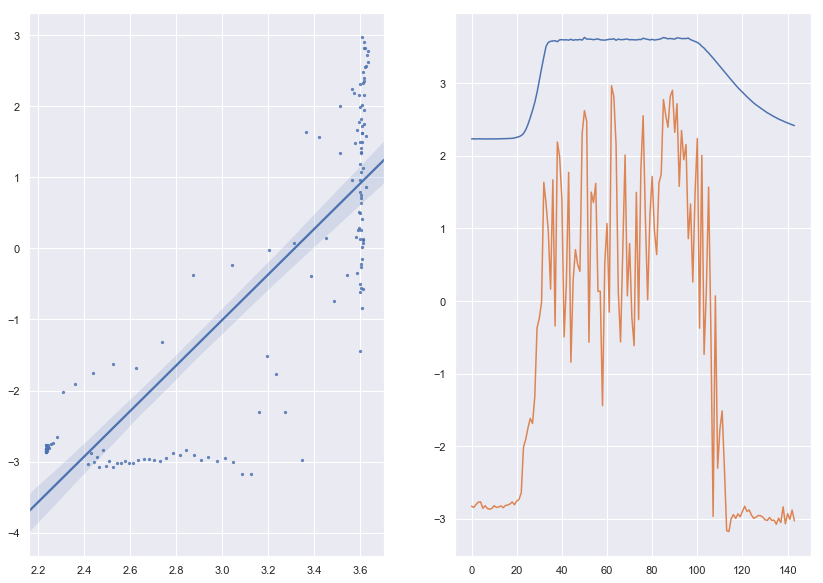

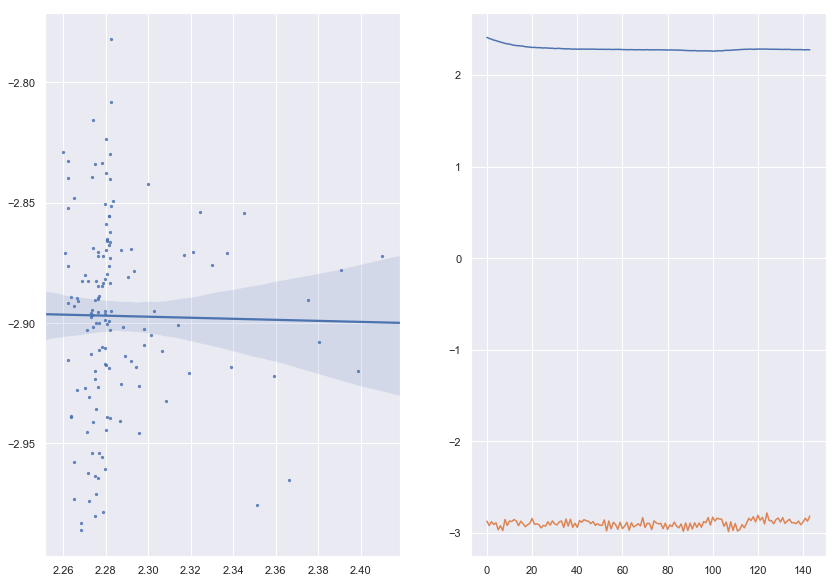

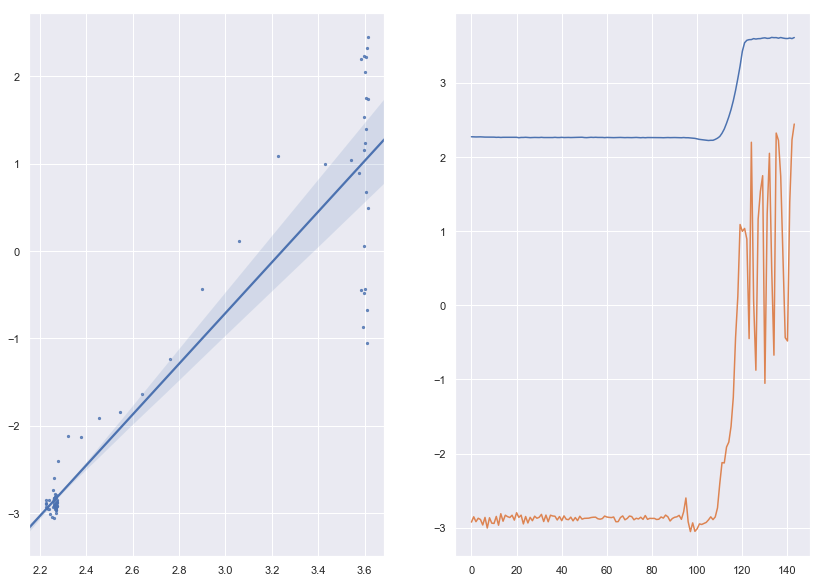

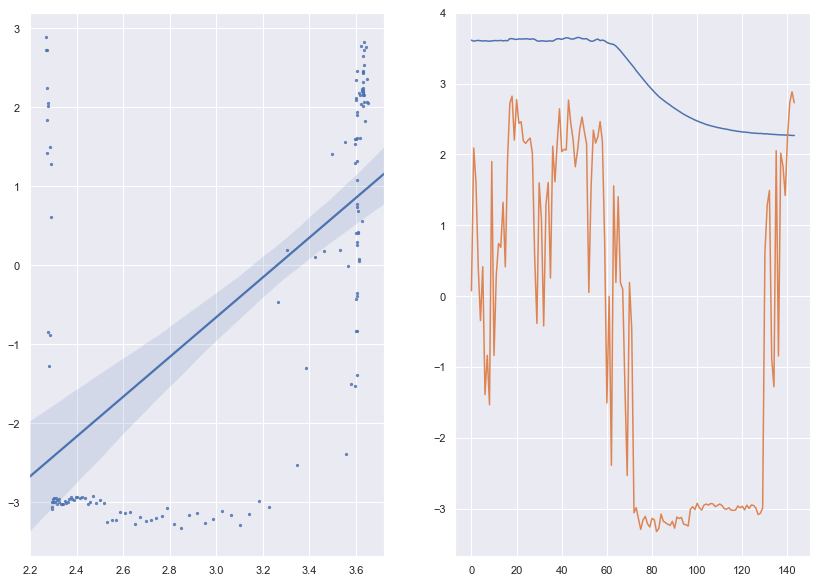

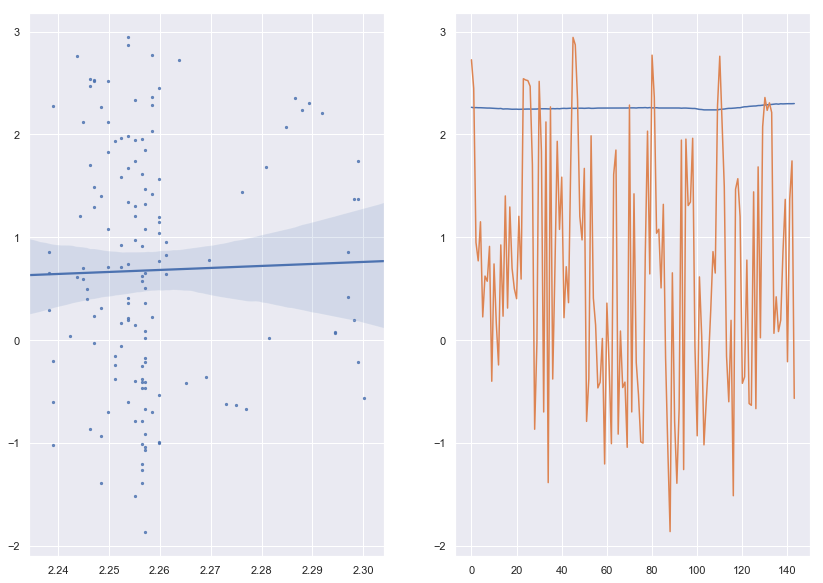

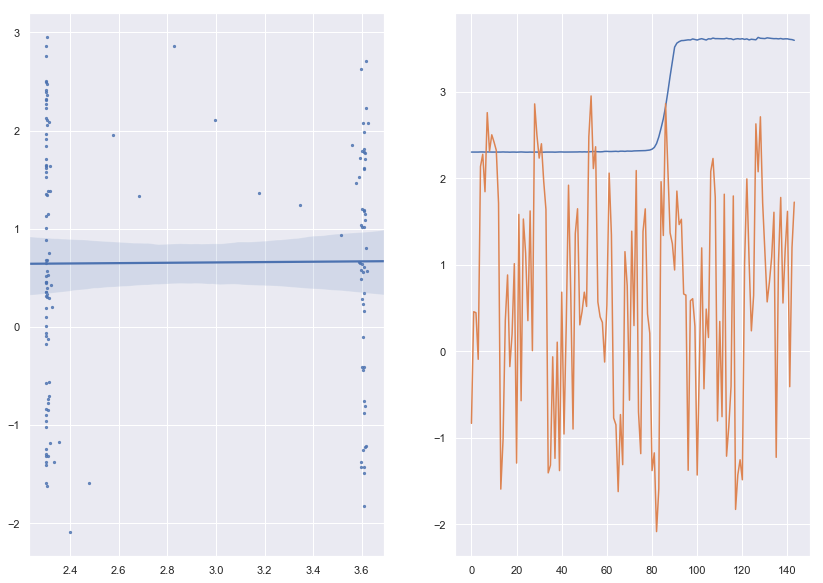

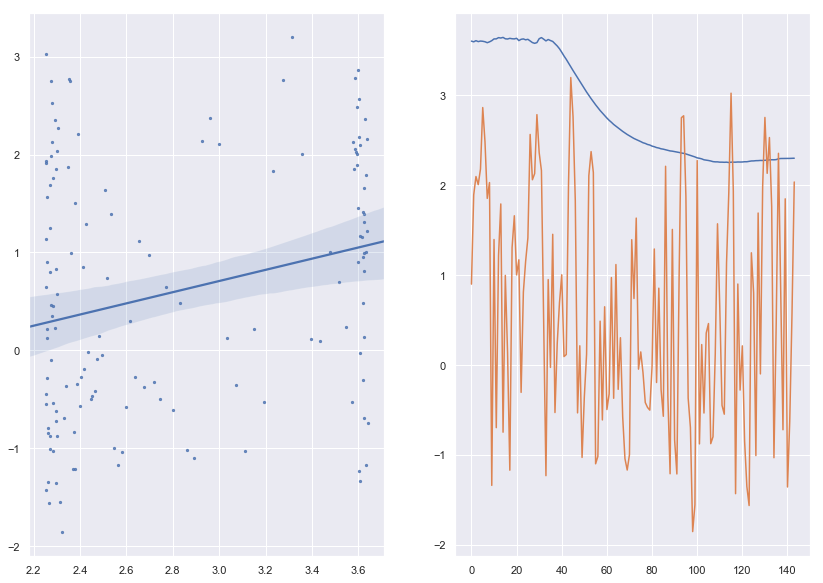

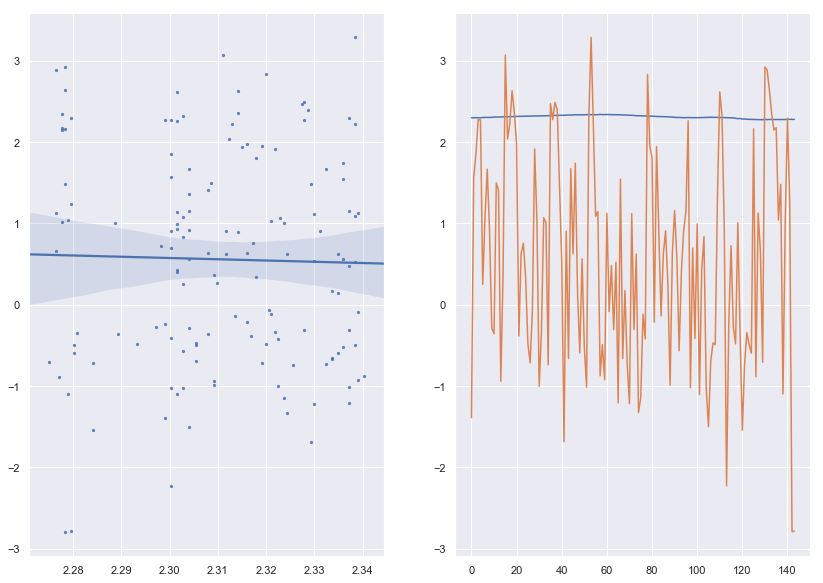

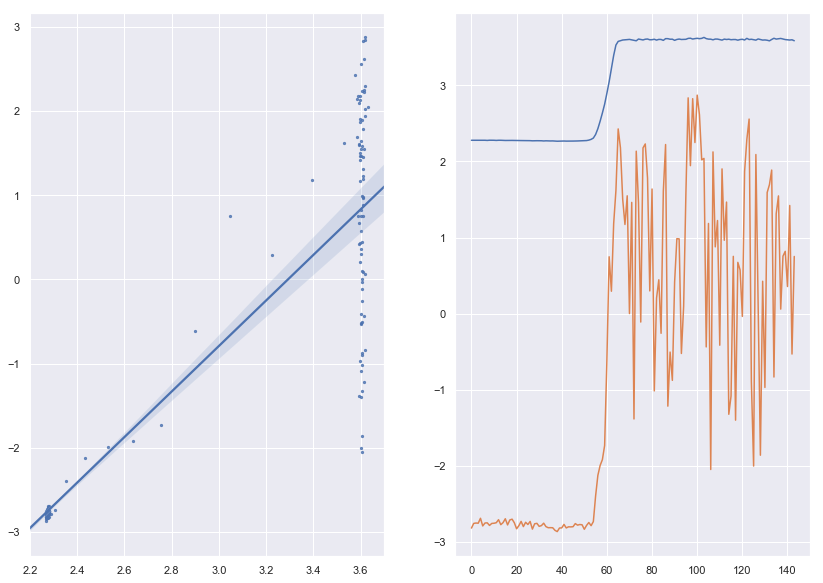

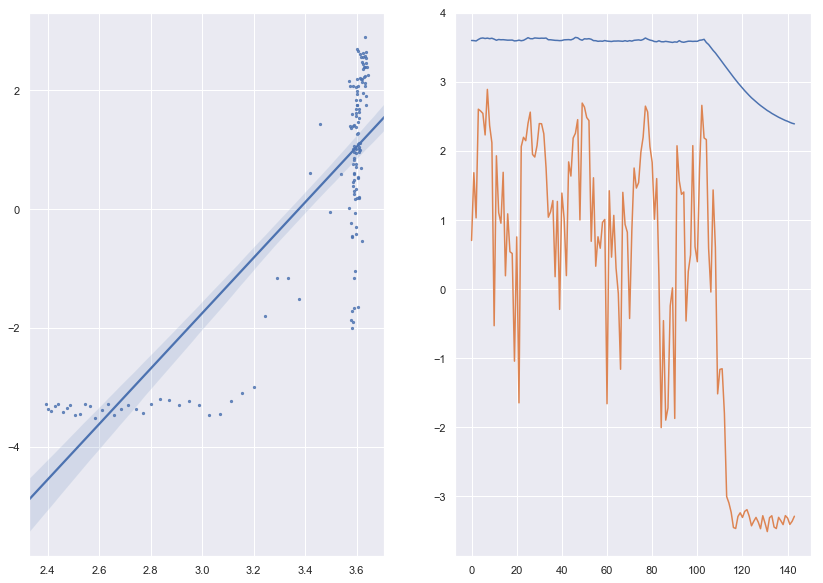

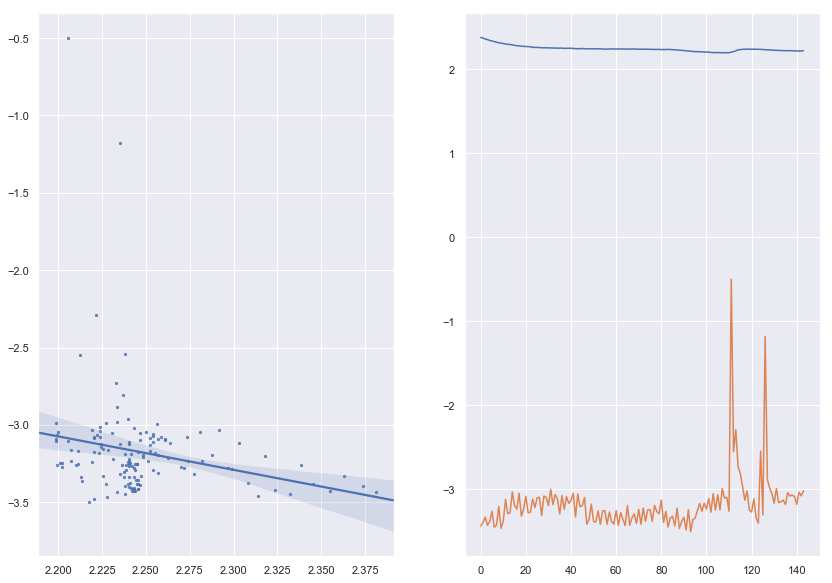

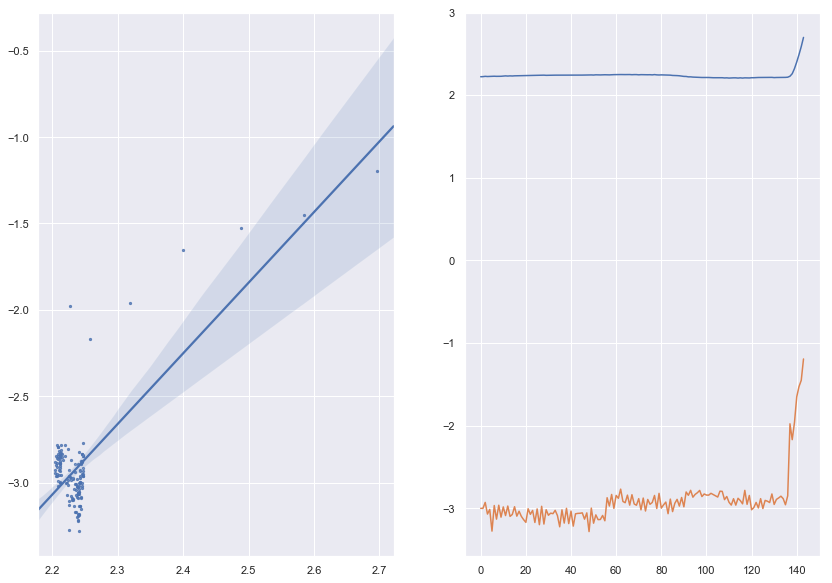

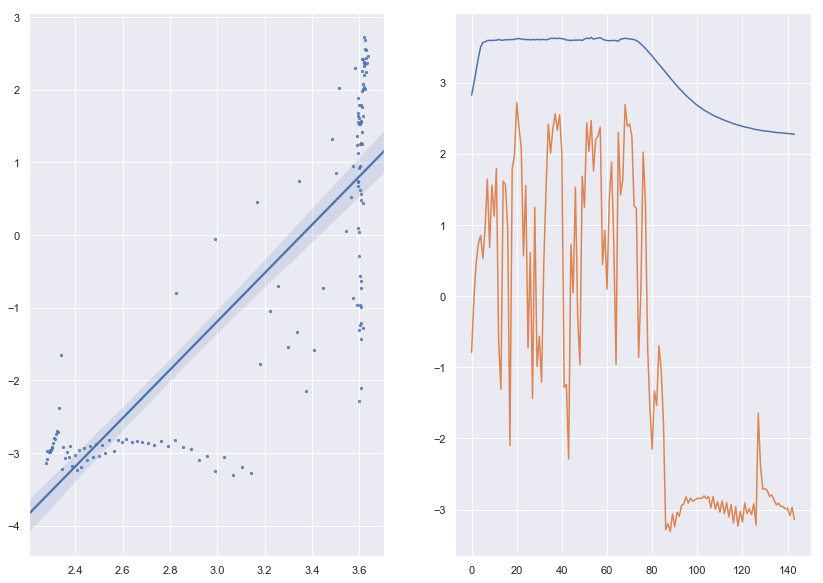

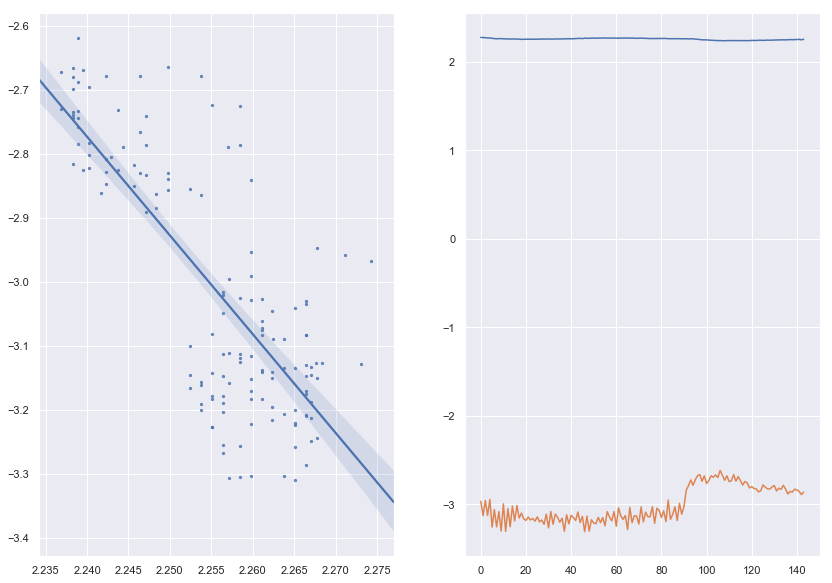

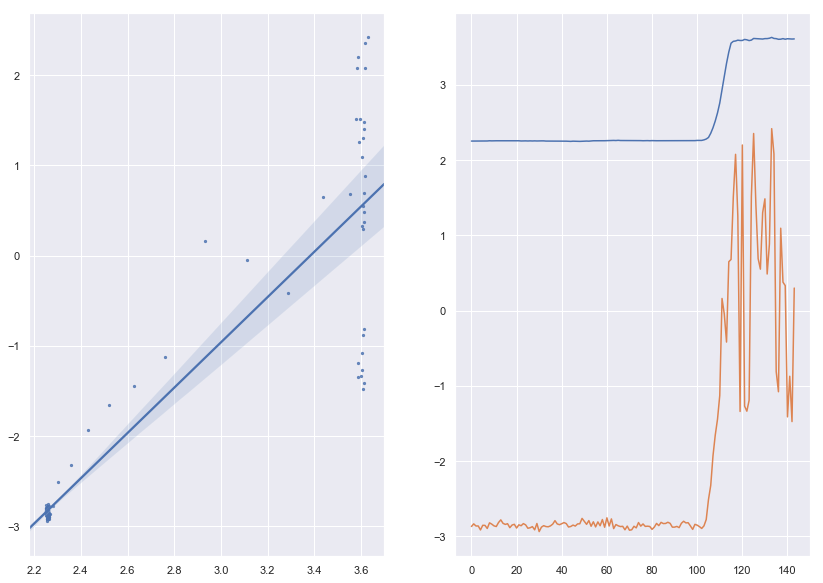

In [341]:
gap = 6*24  # set size of the rolling window 

x = np.asarray(np.log(temp.dropna().iloc[:, -3]))  # temperature vector
y = np.asarray(np.log(temp.dropna().iloc[:, -1]))  # power vector

# calculate the rolling corelation coefficient
for i in np.arange((x.shape[0]/gap)-1):
    plt.subplot(1,2,1)
    sns.regplot(x=x[int(gap*(i)):int(gap*(i+1))], y=y[int(gap*(i)):int(gap*(i+1))], marker=".", scatter_kws={"s": 20})
    plt.subplot(1,2,2)
    plt.plot(x[int(gap*(i)):int(gap*(i+1))])
    plt.plot(y[int(gap*(i)):int(gap*(i+1))])
    plt.show()